# First glance at Bayesian neural network
In this notebook we compare the non-Bayesian and Bayesian neural network which share similar architecture. Bayesian NN provides uncertainty in its prediction while non-Bayesian NN only provides point esitmates. MNIST dataset is used.

## 0.0 Import libraries and set plot format

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_datasets as tfds
import tensorflow_probability as tfp
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import time
import sklearn
from sklearn import datasets
import scipy.stats as ss
from tqdm import tqdm

tfd = tfp.distributions

In [2]:
print(tf.__version__)
print(tfp.__version__)

2.4.1
0.12.1


In [3]:
plt.style.use('ggplot')

SMALL_SIZE = 12
MEDIUM_SIZE = 15
BIGGER_SIZE = 18

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

## 1.0 Load datasets

In [4]:
# the data, split between train and test sets
(X_train, y_train), (X_test, y_test) = keras.datasets.mnist.load_data()
X_train, X_test = X_train.astype(np.float32)/255., X_test.astype(np.float32)/255.

X_train = np.expand_dims(X_train,-1)
X_test = np.expand_dims(X_test,-1)
print(f"Training input data size is {X_train.shape}")
print(f"Training output data size is {y_train.shape}")

11493376/11490434 [==============================] - 0s 0us/step
Training input data size is (60000, 28, 28, 1)
Training output data size is (60000,)


In [97]:
X_train.dtype

dtype('float32')

In [98]:
input_shape = X_train[0].shape
print(f'input shape is: {input_shape}')
print(f'outputs can be:  {set(y_train)}')

input shape is: (28, 28, 1)
outputs can be:  {0, 1, 2, 3, 4, 5, 6, 7, 8, 9}


## 2.0 Non-Bayesian neural network model

### 2.1 Build non-Bayesian model

In [99]:
mymodel = keras.models.Sequential([
                                   layers.Conv2D(kernel_size=(3,3),filters=32,activation='relu',input_shape=input_shape),
                                   layers.MaxPooling2D(pool_size=(2,2),strides=None, padding='valid'),
                                   layers.Flatten(),
                                   layers.Dense(100,activation='relu'),
                                   layers.Dropout(0.2),
                                   layers.Dense(10, activation='softmax'),
            
])

In [100]:
def run_experiment(model,loss, X_train,y_train,X_test,y_test, epochs, patience):
  '''compile, fit, evaluate in one function''' 
  early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss',mode = 'min', patience=patience)
  model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=1e-3),
        loss=loss,
        metrics=['accuracy'],
    )
  print("training the model...")
  history = model.fit(X_train,y_train,validation_split=0.1,epochs=epochs,verbose=1,callbacks=[early_stop])
  print("evaluating model on train data")
  loss_t, acc_t = model.evaluate(X_train, y_train)
  print(f"Trainning loss: {loss_t :.3f}, training acc: {acc_t:.3f}")

  print("evaluating model on test data")
  loss_tt, acc_tt = model.evaluate(X_test, y_test)
  print(f"Testing loss: {loss_tt:.3f}, testing acc: {acc_tt:.3f}")
  return history

### 2.2 Run non-Bayesian model

In [101]:
loss='sparse_categorical_crossentropy'
start= time.time()
history = run_experiment(mymodel,loss, X_train,y_train,X_test,y_test,200,10)
time_cost = time.time()- start
print(f'Training cost {time_cost :.2f} seconds.')

training the model...
Epoch 1/200
1688/1688 [==============================] - 5s 3ms/step - loss: 0.3795 - accuracy: 0.8858 - val_loss: 0.0700 - val_accuracy: 0.9810
Epoch 2/200
1688/1688 [==============================] - 5s 3ms/step - loss: 0.0804 - accuracy: 0.9756 - val_loss: 0.0582 - val_accuracy: 0.9845
Epoch 3/200
1688/1688 [==============================] - 5s 3ms/step - loss: 0.0516 - accuracy: 0.9836 - val_loss: 0.0507 - val_accuracy: 0.9870
Epoch 4/200
1688/1688 [==============================] - 5s 3ms/step - loss: 0.0409 - accuracy: 0.9869 - val_loss: 0.0423 - val_accuracy: 0.9877
Epoch 5/200
1688/1688 [==============================] - 5s 3ms/step - loss: 0.0332 - accuracy: 0.9893 - val_loss: 0.0508 - val_accuracy: 0.9880
Epoch 6/200
1688/1688 [==============================] - 5s 3ms/step - loss: 0.0252 - accuracy: 0.9919 - val_loss: 0.0525 - val_accuracy: 0.9875
Epoch 7/200
1688/1688 [==============================] - 5s 3ms/step - loss: 0.0202 - accuracy: 0.9933 - val

In [102]:
mymodel.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 5408)              0         
_________________________________________________________________
dense (Dense)                (None, 100)               540900    
_________________________________________________________________
dropout (Dropout)            (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                1010      
Total params: 542,230
Trainable params: 542,230
Non-trainable params: 0
________________________________________________

In [103]:
mymodel.save('Normal_CNN.h5')

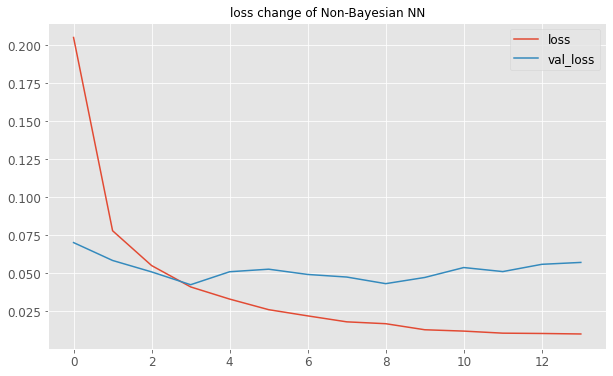

In [104]:
pd.DataFrame(history.history)[['loss','val_loss']].plot(figsize=(10,6))
plt.title("loss change of Non-Bayesian NN")
plt.show()

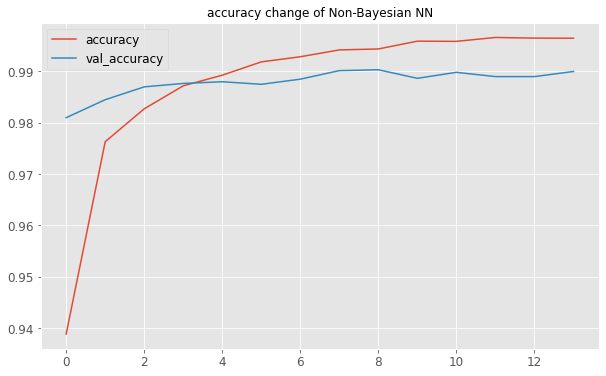

In [105]:
pd.DataFrame(history.history)[['accuracy','val_accuracy']].plot(figsize=(10,6))
plt.title("accuracy change of Non-Bayesian NN")
plt.show()

### 2.3 The prediction of non-Bayesian model
we can see the prediction(take X_test[0] as an example) is the same all the time as the Non-Bayesian model provides point esitmation

In [106]:
for i in range(5):
  print(f"iter {i}")
  print(f"predicted label: {np.argmax(mymodel.predict(X_test)[0])}")
  print(f"predicted mat: {mymodel.predict(X_test)[0]}")
  

iter 0
predicted label: 7
predicted mat: [1.4147609e-14 3.2601582e-12 8.1334917e-13 2.9861624e-10 1.2969266e-17
 1.7871613e-13 6.8015160e-21 1.0000000e+00 1.7598164e-13 6.2512777e-09]
iter 1
predicted label: 7
predicted mat: [1.4147609e-14 3.2601582e-12 8.1334917e-13 2.9861624e-10 1.2969266e-17
 1.7871613e-13 6.8015160e-21 1.0000000e+00 1.7598164e-13 6.2512777e-09]
iter 2
predicted label: 7
predicted mat: [1.4147609e-14 3.2601582e-12 8.1334917e-13 2.9861624e-10 1.2969266e-17
 1.7871613e-13 6.8015160e-21 1.0000000e+00 1.7598164e-13 6.2512777e-09]
iter 3
predicted label: 7
predicted mat: [1.4147609e-14 3.2601582e-12 8.1334917e-13 2.9861624e-10 1.2969266e-17
 1.7871613e-13 6.8015160e-21 1.0000000e+00 1.7598164e-13 6.2512777e-09]
iter 4
predicted label: 7
predicted mat: [1.4147609e-14 3.2601582e-12 8.1334917e-13 2.9861624e-10 1.2969266e-17
 1.7871613e-13 6.8015160e-21 1.0000000e+00 1.7598164e-13 6.2512777e-09]


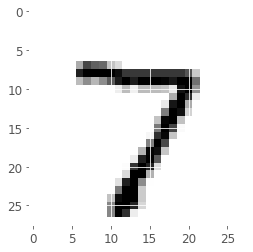

In [107]:
plt.imshow(X_test[0].reshape(28,28),cmap='binary')
plt.show()

## 3.0 Bayesian Neural Netwrok

### 3.1 Define prior and posterior for Densevairantion layers (can be skipped for now)
not used in BNN classification here

In [6]:
# prior is non-trainable, so we use tfp.layers.DistributionLambda
# multivariate normal distribution is often chosen
def prior(kernel_size, bias_size, dtype = None):
  n = kernel_size+bias_size
  prior_model = keras.models.Sequential([
                                         tfp.layers.DistributionLambda(lambda t: tfd.MultivariateNormalDiag(loc = tf.zeros(n),scale_diag=tf.ones(n)))
  ])
  print(f'PRIOR: kerel size is {kernel_size}, bias size is {bias_size}\n ')
  return prior_model

# using tfp.layers.VariableLayer to create a trainable layer and followed by the layer
def posterior(kernel_size, bias_size, dtype = None):
  n = kernel_size+bias_size
  posterior_model = keras.models.Sequential([
                                             tfp.layers.VariableLayer(
                                                 tfp.layers.MultivariateNormalTriL.params_size(n),dtype=dtype
                                             ),
                                             tfp.layers.MultivariateNormalTriL(n)
  ])
  print(f'POSTERIOR: kerel size is {kernel_size}, bias size is {bias_size}\n ')
  return posterior_model

### 3.2 Define KL divergence for Denseflipout layers
prior and posterior are default in the layer

In [7]:
kernel_div_fn = lambda q,p,_: tfd.kl_divergence(q,p)/X_train.shape[0]

### 3.3 Build Bayesian model

In [38]:
# Sequential model, similar structure with the Non-Bayesian model, but no dropout, since VI(minimizing KL is used)
myBNN = keras.models.Sequential([
                                 tfp.layers.Convolution2DFlipout(filters=32,kernel_size=(3,3),padding='valid',activation='relu',kernel_divergence_fn=kernel_div_fn),
                                 layers.MaxPooling2D(pool_size=(2,2),padding='valid',strides=None),
                                 layers.Flatten(),
                                 tfp.layers.DenseFlipout(100,activation='relu',kernel_divergence_fn=kernel_div_fn),
                                 tfp.layers.DenseFlipout(10,activation='softmax',kernel_divergence_fn=kernel_div_fn) # 10 classes

])

### 3.4 Run Bayesian model


In [39]:
# same as Non-Bayesian model
loss='sparse_categorical_crossentropy'
myBNN.compile(
      optimizer=keras.optimizers.Adam(learning_rate=1e-3),
      loss=loss,
      metrics=[tf.keras.metrics.SparseCategoricalCrossentropy(name='Cat_Etp'),'accuracy'],
  )

In [40]:
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',mode = 'max', patience=5)
print("training the model...")
BNNhistory = myBNN.fit(X_train,y_train,validation_split=0.1,epochs=200,verbose=1,callbacks=[early_stop])

training the model...
Epoch 1/200


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/base_layer.py:2281: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  warnings.warn('`layer.add_variable` is deprecated and '


1688/1688 [==============================] - 42s 5ms/step - loss: 21.2679 - Cat_Etp: 0.5367 - accuracy: 0.8242 - val_loss: 14.5104 - val_Cat_Etp: 0.1077 - val_accuracy: 0.9678
Epoch 2/200
1688/1688 [==============================] - 8s 5ms/step - loss: 12.7137 - Cat_Etp: 0.1141 - accuracy: 0.9639 - val_loss: 8.2540 - val_Cat_Etp: 0.0839 - val_accuracy: 0.9763
Epoch 3/200
1688/1688 [==============================] - 8s 5ms/step - loss: 7.3245 - Cat_Etp: 0.0767 - accuracy: 0.9764 - val_loss: 5.2181 - val_Cat_Etp: 0.0760 - val_accuracy: 0.9782
Epoch 4/200
1688/1688 [==============================] - 8s 5ms/step - loss: 4.7546 - Cat_Etp: 0.0688 - accuracy: 0.9786 - val_loss: 3.6128 - val_Cat_Etp: 0.0794 - val_accuracy: 0.9767
Epoch 5/200
1688/1688 [==============================] - 8s 5ms/step - loss: 3.3035 - Cat_Etp: 0.0638 - accuracy: 0.9802 - val_loss: 2.5689 - val_Cat_Etp: 0.0752 - val_accuracy: 0.9797
Epoch 6/200
1688/1688 [==============================] - 8s 5ms/step - loss: 2.3651

In [41]:
print("evaluating model on test data")
loss_tt, Cat_Etp, acc_tt = myBNN.evaluate(X_test, y_test)
print(f"Testing loss: {loss_tt:.3f}, testing acc: {acc_tt:.3f}")

evaluating model on test data
313/313 [==============================] - 1s 3ms/step - loss: 0.4672 - Cat_Etp: 0.0824 - accuracy: 0.9769
Testing loss: 0.467, testing acc: 0.977


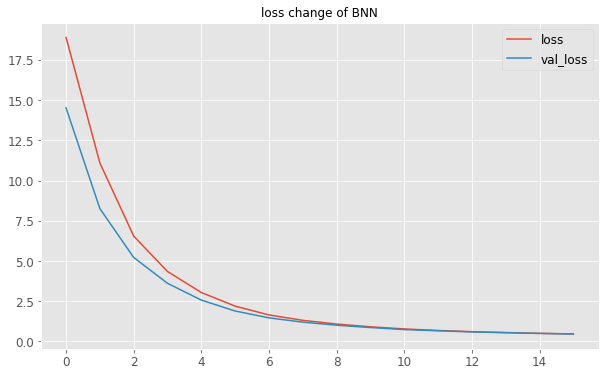

In [42]:
pd.DataFrame(BNNhistory.history)[['loss','val_loss']].plot(figsize=(10,6))
plt.title("loss change of BNN")
plt.legend()
plt.show()

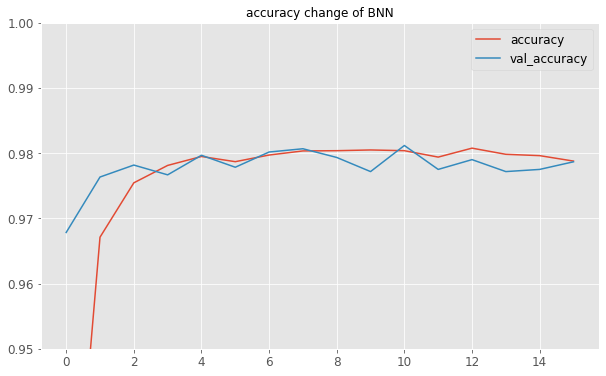

In [43]:
pd.DataFrame(BNNhistory.history)[['accuracy','val_accuracy']].plot(figsize=(10,6))
plt.title("accuracy change of BNN")
plt.ylim(0.95,1)
plt.legend()
plt.show()

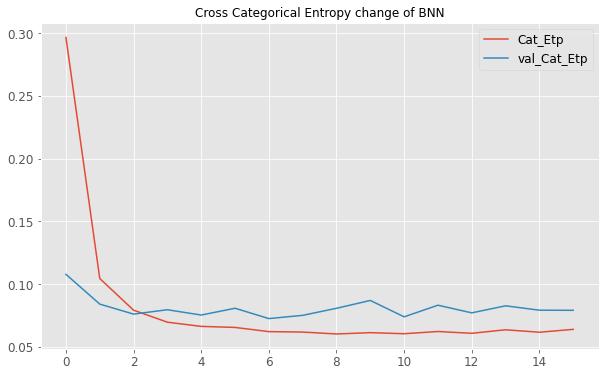

In [44]:
pd.DataFrame(BNNhistory.history)[['Cat_Etp','val_Cat_Etp']].plot(figsize=(10,6))
plt.title("Cross Categorical Entropy change of BNN")
plt.legend()
plt.show()

Note that every weight in the network is now sampled from a normal distribution. The normal distribution has two paramters and therefore we have almost doubled our paramters (we don't use a distribution for bias terms) in the network. 

In [45]:
myBNN.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_flipout_1 (Conv2DFlip (None, 26, 26, 32)        608       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 5408)              0         
_________________________________________________________________
dense_flipout_2 (DenseFlipou (None, 100)               1081700   
_________________________________________________________________
dense_flipout_3 (DenseFlipou (None, 10)                2010      
Total params: 1,084,318
Trainable params: 1,084,318
Non-trainable params: 0
_________________________________________________________________


In [46]:
myBNN.save('Bayesian_CNN.h5')

### 3.5 The prediction of Bayesian model

we can see the distribution variates every time, so we run model.predict 50 time and calculate the mean and std

In [47]:
for i in range(5):
  print(f"iter {i}")
  print(f"predicted label: {np.argmax(myBNN.predict(X_test)[0])}")
  print(f"predicted mat: {myBNN.predict(X_test)[0]}")

iter 0
predicted label: 7
predicted mat: [6.6094602e-11 1.0095420e-07 6.3886019e-10 1.2954941e-07 9.9590371e-12
 2.7330438e-09 1.9182373e-12 9.9999976e-01 2.7439970e-09 1.7819000e-08]
iter 1
predicted label: 7
predicted mat: [7.1502296e-12 9.7063557e-10 4.5409166e-08 4.8488646e-06 3.9481100e-14
 2.2790325e-10 3.4885287e-15 9.9999511e-01 1.3476686e-09 1.7879130e-09]
iter 2
predicted label: 7
predicted mat: [1.2907955e-09 3.6705951e-06 2.9075937e-07 1.3845819e-06 1.1806301e-09
 2.3681183e-08 4.1340410e-11 9.9999142e-01 1.5216995e-07 3.1186623e-06]
iter 3
predicted label: 7
predicted mat: [1.3525463e-08 3.3040749e-08 6.1103066e-08 4.9887567e-06 7.4366388e-11
 1.4354929e-07 6.6178890e-12 9.9999297e-01 2.7660829e-07 1.5595843e-06]
iter 4
predicted label: 7
predicted mat: [5.41524070e-09 2.02839396e-06 2.28879848e-08 1.05943045e-07
 4.67355182e-11 8.07678750e-12 2.87142434e-13 9.99997616e-01
 3.36586581e-08 2.44120827e-07]


#### 3.5.1 Run model.evaluate 50 times directly
then calculate the mean and std fo accuracy, loss

In [10]:
# myBNN= keras.models.load_model('/content/Bayesian_CNN.h5') # not working in Google Colab, reason unknown

Mounted at /content/drive


OSError: ignored

In [48]:
acc_tt_esb=[]
loss_tt_esb = []
for i in tqdm(range(50)):
  acc_tt_esb.append(myBNN.evaluate(X_test, y_test,verbose=0)[2])
  loss_tt_esb.append(myBNN.evaluate(X_test, y_test,verbose=0)[0])

acc_tt_esb = np.array(acc_tt_esb)
acc_mean = np.mean(acc_tt_esb)
acc_std = np.std(acc_tt_esb,ddof=1)

loss_tt_esb = np.array(loss_tt_esb)
loss_mean = np.mean(loss_tt_esb)
loss_std = np.std(loss_tt_esb,ddof=1)

print(f'the mean and std of predcion accuracy are: {acc_mean :.3f}, {acc_std :.6f}')
print(f'the mean and std of predcion loss are: {loss_mean :.3f}, {loss_std :.6f}')


100%|██████████| 50/50 [01:26<00:00,  1.72s/it]

the mean and std of predcion accuracy are: 0.975, 0.001159
the mean and std of predcion loss are: 0.464, 0.004106


### 3.6 Plot the result

#### 3.6.1 Prepare data for each digit number

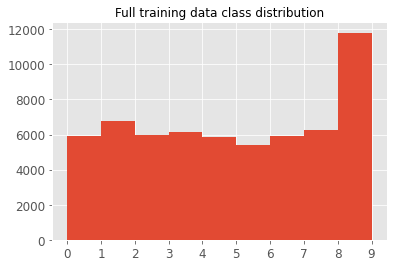

In [ ]:
plt.hist(y_train,bins=[0,1,2,3,4,5,6,7,8,9])
plt.xticks([0,1,2,3,4,5,6,7,8,9])
plt.title("Full training data class distribution")
plt.show()

In [ ]:
keys = ['idx_0','idx_1','idx_2','idx_3','idx_4','idx_5','idx_6','idx_7','idx_8','idx_9']
cat_dic = {}
for i in range(10):
  cat_dic[keys[i]]=np.array(np.where(y_test == i)).reshape(-1)

In [ ]:
pred_loss=np.zeros((10,10))
pred_cat_etp = np.zeros((10,10))
cat_acc =np.zeros((10,10))

for i in tqdm(range(10)):
  for k in range(10):
    pred_loss1,pred_cat_etp1, cat_acc1 = myBNN.evaluate(X_test[cat_dic[keys[k]]],y_test[np.where(y_test==k)],verbose=0)
    pred_loss[i,k] = pred_loss1
    pred_cat_etp[i,k]=pred_cat_etp1
    cat_acc[i,k]=cat_acc1



100%|██████████| 10/10 [00:12<00:00,  1.25s/it]


In [ ]:
cat_acc_mean = cat_acc.mean(axis=1)
cat_acc__std = cat_acc.std(axis=1)

#### 3.6.2 Visualize the mean and std for each digit

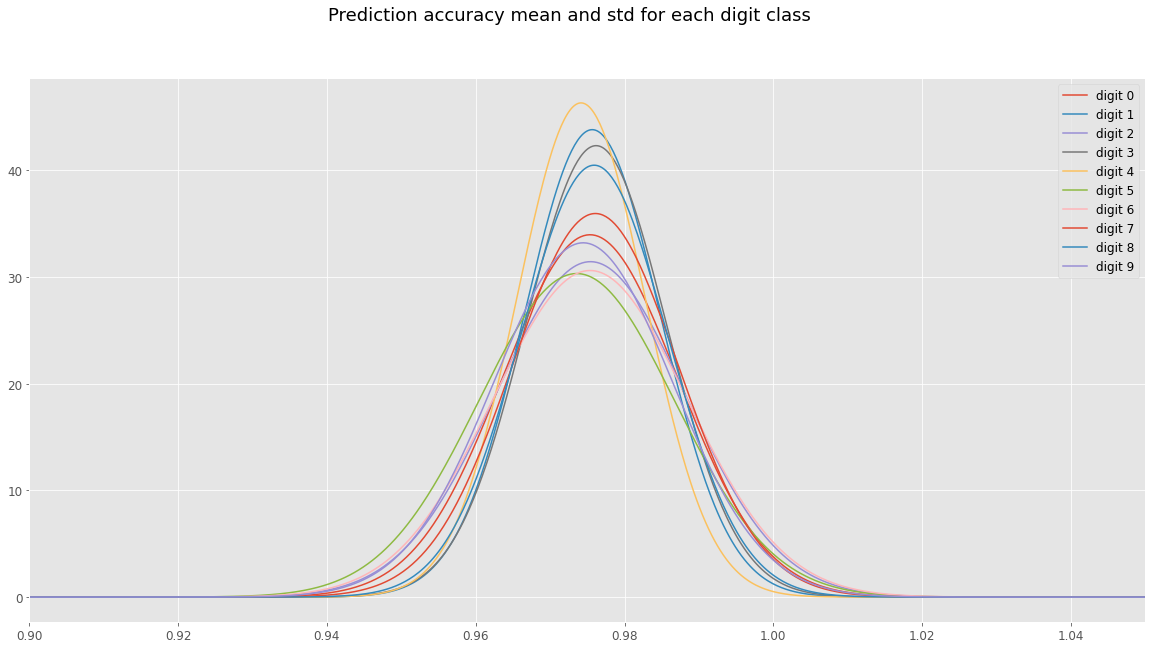

In [ ]:
plt.figure(figsize=(20,10))
plt.suptitle("Prediction accuracy mean and std for each digit class")
x = np.linspace(0,2,10000)
for i in range(10):
  plt.plot(x, ss.norm.pdf(x,cat_acc_mean[i],cat_acc__std[i]),label=f'digit {i}')
  plt.legend()
  plt.xlim(0.9,1.05)
  # plt.legend()
plt.show()

#### 3.6.3 Visulize the histogram of prediction for each digit
easy to see the wrong prediction label, then we can tell wether the wrong prediction makes sense

In [ ]:
pred_dic={}
for k in cat_dic.keys():
  pred_dic[k] = np.argmax(myBNN(X_test[cat_dic[k]]).numpy(),axis=1)

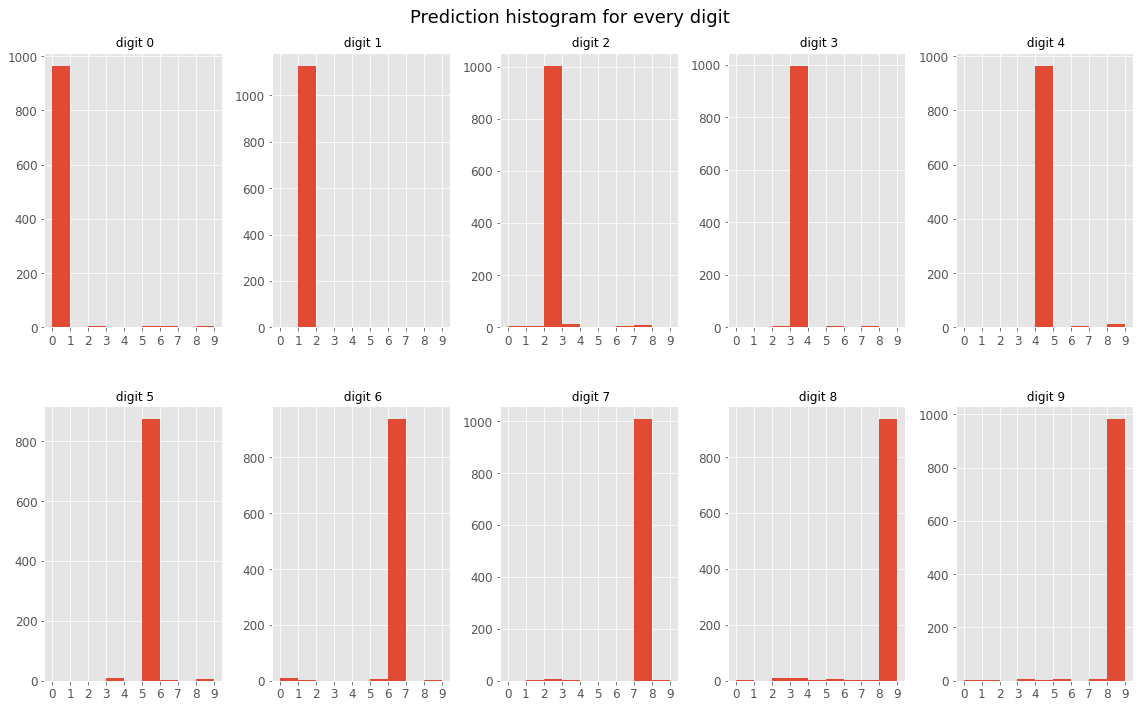

In [ ]:
plt.figure(figsize=(16, 10))
plt.suptitle('Prediction histogram for every digit\n',y=0.98)
for i in range(10):
  plt.subplot(2,5, i+1)
  plt.hist(pred_dic[keys[i]],density=False,bins=[0,1,2,3,4,5,6,7,8,9])
  # sns.distplot(pred_dic[keys[i]],bins=[0,1,2,3,4,5,6,7,8,9])
  plt.title(f'\n \n digit {i}')
  plt.xticks([0,1,2,3,4,5,6,7,8,9])
  plt.tight_layout()

plt.show()

In [ ]:
X_test[cat_dic[keys[0]]].shape

(980, 28, 28, 1)

### 3.7 Predction on unseen data
we can see big standard deviation in prediction in Bayesian NN, while we only get one point estimation for non-Bayesian NN

In [35]:
# generate unseen data
unseen_digit = np.zeros((1,28,28,1))
loc = np.random.choice(28,(40,2))
col = np.random.choice(255,40)
for i in range(40):
  unseen_digit[0,loc[i][0],loc[i][1],0]= col[i]

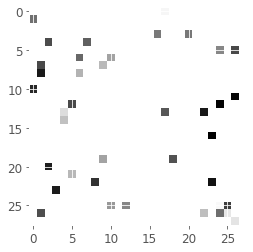

In [36]:
plt.imshow(unseen_digit.reshape(28,28),cmap='binary')
plt.show()

In [92]:
unseen_pred = np.zeros((1000,1))
for i in tqdm(range(1000)):
  unseen_pred[i,0] = np.argmax(myBNN.predict(unseen_digit),axis=1)

100%|██████████| 1000/1000 [00:32<00:00, 31.06it/s]


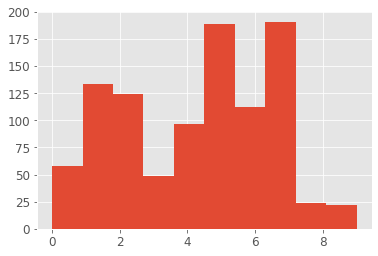

In [93]:
plt.hist(unseen_pred)
plt.show()

## 4.0 Probabilisitic Bayesian neural network
try to use tfp.layers.OneHotCategorical() to output 10 learnt distributions for 10 digits, but the model is not learning, reason unkown yet :(

In [ ]:
# Sequential model, similar structure with the Non-Bayesian model, but no dropout, since VI(minimizing KL is used)
myProbBNN = keras.models.Sequential([
                                 tfp.layers.Convolution2DFlipout(filters=32,kernel_size=(3,3),padding='valid',activation='relu',kernel_divergence_fn=kernel_div_fn),
                                 layers.MaxPooling2D(pool_size=(2,2),padding='valid',strides=None),
                                 layers.Flatten(),
                                 tfp.layers.DenseFlipout(100,activation='relu',kernel_divergence_fn=kernel_div_fn),
                                 tfp.layers.DenseFlipout(tfp.layers.OneHotCategorical.params_size(10),kernel_divergence_fn=kernel_div_fn,activation='relu'),
                                 tfp.layers.OneHotCategorical(10)
])

In [ ]:
def neg_log_lik(y_true, y_pred): 
  return - y_pred.log_prob(y_true)

In [ ]:
myProbBNN.compile(optimizer='Adam',loss=neg_log_lik,metrics=['accuracy'])

In [ ]:
probBNNHistory = myProbBNN.fit(X_train,y_train,validation_split=0.1,epochs=200,callbacks=[early_stop])

Epoch 1/200


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/base_layer.py:2281: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  warnings.warn('`layer.add_variable` is deprecated and '


1688/1688 [==============================] - 11s 5ms/step - loss: 7688676.6963 - accuracy: 0.1006 - val_loss: 73151312.0000 - val_accuracy: 0.0975
Epoch 2/200
1688/1688 [==============================] - 9s 5ms/step - loss: 110135516.8028 - accuracy: 0.1002 - val_loss: 241581440.0000 - val_accuracy: 0.0993
Epoch 3/200
1688/1688 [==============================] - 9s 5ms/step - loss: 294189202.9272 - accuracy: 0.1041 - val_loss: 469680288.0000 - val_accuracy: 0.0972
Epoch 4/200
1688/1688 [==============================] - 9s 5ms/step - loss: 533735070.0675 - accuracy: 0.0975 - val_loss: 748003264.0000 - val_accuracy: 0.1037
Epoch 5/200
1688/1688 [==============================] - 9s 5ms/step - loss: 822682305.0989 - accuracy: 0.0984 - val_loss: 1075418880.0000 - val_accuracy: 0.1008
Epoch 6/200
1688/1688 [==============================] - 9s 5ms/step - loss: 1159162235.5287 - accuracy: 0.1027 - val_loss: 1448762496.0000 - val_accuracy: 0.0975
Epoch 7/200
1688/1688 [======================